In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FUNK_SVD_MODEL_DIR
from src.data.load_dataset import get_train_data, get_test_data, get_games_data
from src.recommender import GameRecommender

In [13]:
# Load data and initialize recommender
train_data = get_train_data()
test_data = get_test_data()
games_data = get_games_data()
print(f"Training: {len(train_data)} samples from {len(np.unique(train_data['UserId']))} users")
print(f"Testing: {len(test_data)} samples from {len(np.unique(test_data['UserId']))} users")

recommender = GameRecommender(train_data, games_data)
recommender.load(FUNK_SVD_MODEL_DIR)


Training: 81142 samples from 960 users
Testing: 18858 samples from 885 users


2025-04-19 20:17:38.812 | DEBUG    | src.models.funk_svd:load_model:280 - Loading model from C:\Ukma\coursework\funk-svd\data\models\funk_svd


In [14]:
# Core analysis functions
def analyze_user_predictions(user_id):
    """Analyze predictions for a single user without generating recommendations"""
    user_id = int(user_id)

    # Get test items for this user using DataFrame filtering
    user_test_items = test_data[test_data['UserId'] == user_id]
    if user_test_items.empty:
        return pd.DataFrame()

    # Get predictions
    item_ids = user_test_items['BGGId'].astype(int).tolist()
    predictions = recommender.get_predictions(user_id, item_ids)

    # Process results
    results = []
    for _, item in user_test_items.iterrows():
        item_id = int(item['BGGId'])
        if item_id in predictions:
            results.append({
                'ItemId': item_id,
                'Actual': float(item['Rating']),
                'Predicted': float(predictions[item_id]),
                'Error': float(item['Rating']) - float(predictions[item_id])
            })

    return pd.DataFrame(results)


def analyze_users(max_users=100):
    """Analyze a sample of users - only predictions, no recommendations"""
    # Get unique user IDs and sample
    test_user_ids = test_data['UserId'].unique()

    # Take a sample if there are more users than max_users
    if len(test_user_ids) > max_users:
        np.random.seed(42)  # For reproducibility
        test_user_ids = np.random.choice(test_user_ids, max_users, replace=False)

    # Collect results
    results = []
    for user_id in test_user_ids:
        predictions_df = analyze_user_predictions(user_id)
        if not predictions_df.empty:
            predictions_df['UserId'] = user_id
            results.append(predictions_df)

    return pd.concat(results) if results else pd.DataFrame()


In [15]:
# Visualization functions
def plot_predictions(df, title):
    """Plot actual vs predicted ratings"""
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Actual'], df['Predicted'], alpha=0.3)
    plt.plot([1, 10], [1, 10], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_error_distribution(df):
    """Plot distribution of prediction errors"""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Error'], bins=20, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Prediction Results:
    ItemId  Actual  Predicted     Error
0   128621     8.0   7.293785  0.706215
1    58281     7.0   7.067589 -0.067589
2   210296     7.0   7.267385 -0.267385
3   188834     6.0   7.162085 -1.162085
4    34635     6.1   7.208737 -1.108737
..     ...     ...        ...       ...
78  245934     7.4   7.556120 -0.156120
79   28720     7.0   7.860715 -0.860715
80  133473     6.0   6.507919 -0.507919
81      12     7.0   7.388597 -0.388597
82  163967     7.2   6.927097  0.272903

[83 rows x 4 columns]


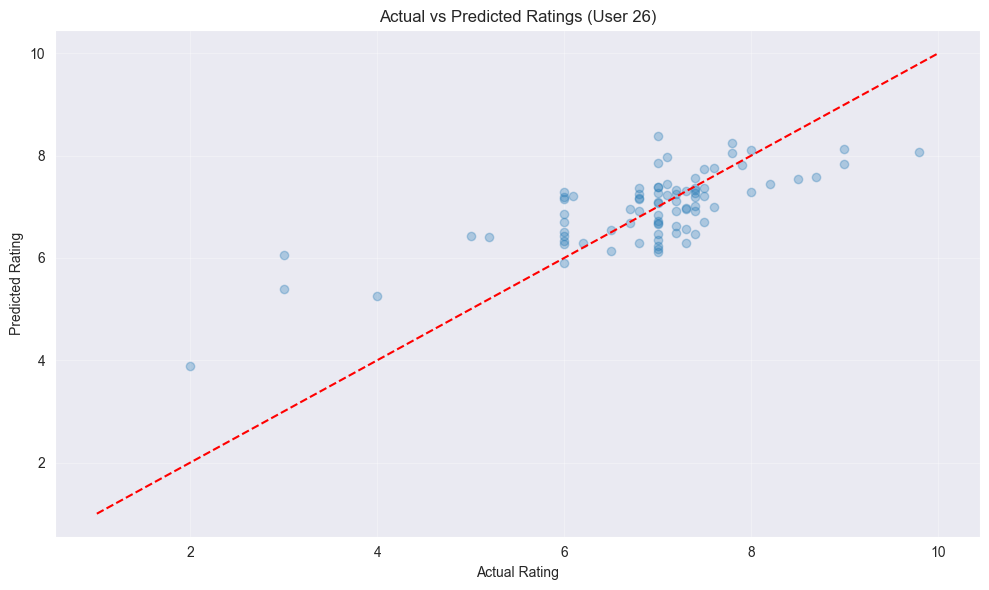

In [16]:
# Analyze a single user
user_id = train_data['UserId'][0]
prediction_df = analyze_user_predictions(user_id)

print("Prediction Results:")
print(prediction_df)

plot_predictions(prediction_df, f'Actual vs Predicted Ratings (User {user_id})')

In [17]:
# Get recommendations with selected attributes
detailed_recs = recommender.get_recommendations(user_id, n=10,
                                                attributes=['Name', 'YearPublished', 'AvgRating', 'NumUserRatings',
                                                            'Family', 'Rank:boardgame'])
pd.DataFrame(detailed_recs)

,BGGId,PredictedRating,Name,YearPublished,AvgRating,NumUserRatings,Family,Rank:boardgame
0,266507,8.561533,Clank!: Legacy – Acquisitions Incorporated,2019,8.69604,4722,Clank!,34
1,246900,8.500380,Eclipse: Second Dawn for the Galaxy,2020,8.67526,4996,Eclipse (Lautapelit.fi),46
2,224517,8.380650,Brass: Birmingham,2018,8.66562,24849,Brass,3
3,270633,8.359448,Aeon's End: The New Age,2019,8.67759,1725,Aeon's End,376
4,284378,8.351517,Kanban EV,2020,8.62853,2791,NaN,139
5,169427,8.347136,Middara: Unintentional Malum – Act 1,2019,8.84724,1544,NaN,545
6,161936,8.298697,Pandemic Legacy: Season 1,2015,8.59678,44614,Pandemic,2
7,291457,8.285489,Gloomhaven: Jaws of the Lion,2020,8.69610,15062,Gloomhaven,6
8,255984,8.271520,Sleeping Gods,2021,8.51042,2496,Sleeping Gods,237
9,55690,8.255878,Kingdom Death: Monster,2015,8.61012,8012,Kingdom Death Monster,50


In [18]:
# Analyze sample of users (100 max)
print("Analyzing sample of users...")
all_predictions_df = analyze_users(max_users=1000)


Analyzing sample of users...


In [19]:
# Calculate performance metrics
rmse = np.sqrt((all_predictions_df['Error'] ** 2).mean())
mae = all_predictions_df['Error'].abs().mean()
corr = np.corrcoef(all_predictions_df['Actual'], all_predictions_df['Predicted'])[0, 1]

print(f"Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


Performance Metrics:
RMSE: 1.1649
MAE: 0.8737
Correlation: 0.5993


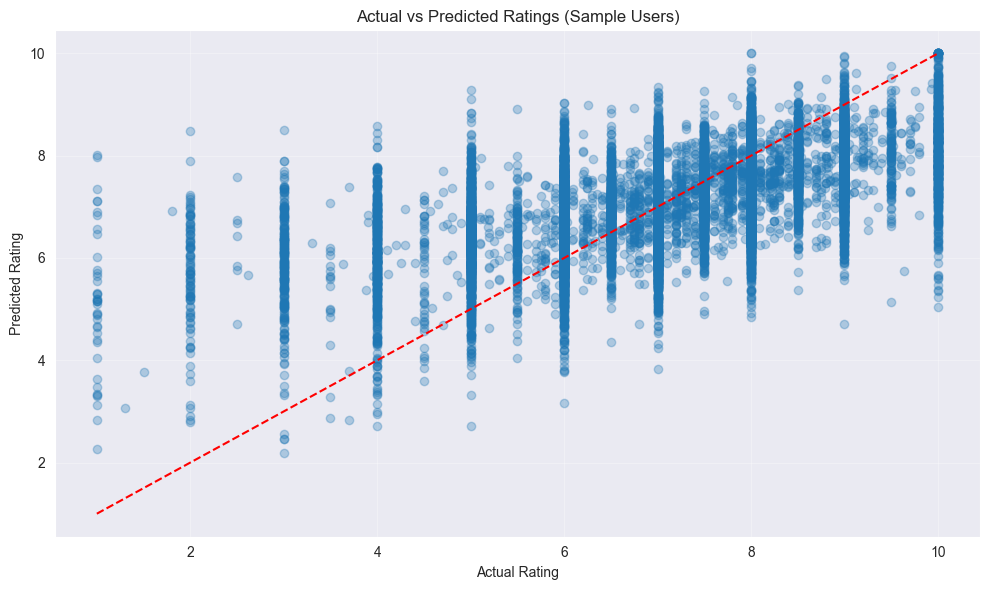

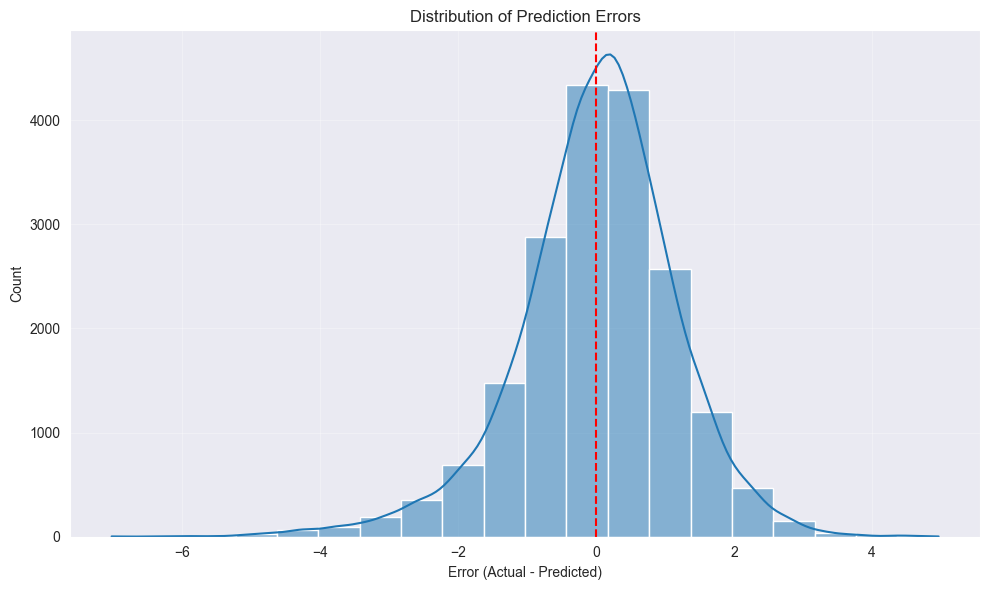

In [20]:
# Visualize overall results
plot_predictions(all_predictions_df, 'Actual vs Predicted Ratings (Sample Users)')
plot_error_distribution(all_predictions_df)


In [21]:
# Compare popular vs personalized recommendations
popular_items = recommender.get_popular_recommendations(train_data, 10)
popular_df = pd.DataFrame(popular_items, columns=['ItemId', 'Score'])

print("Popular Recommendations:")
print(popular_df)

# Compare with a specific user's recommendations
personal_recs = recommender.get_recommendations(user_id)
personal_rec_ids = [rec['BGGId'] for rec in personal_recs]
overlap = len(set(personal_rec_ids).intersection(set(popular_df['ItemId'])))

print(f"\nUser {user_id} Recommendations:")
print(pd.DataFrame(personal_recs))
print(f"\nOverlap with popular items: {overlap} items")


Popular Recommendations:
   ItemId      Score
0  167791  46.576445
1   68448  45.071618
2   30549  44.883919
3  169786  44.804702
4     822  44.289854
5  173346  43.926876
6  161936  43.883380
7  174430  43.710994
8   84876  43.657031
9    3076  43.338779

User 26 Recommendations:
    BGGId  PredictedRating
0  266507         8.561533
1  246900         8.500380
2  224517         8.380650
3  270633         8.359448
4  284378         8.351517
5  169427         8.347136
6  161936         8.298697
7  291457         8.285489
8  255984         8.271520
9   55690         8.255878

Overlap with popular items: 1 items
